# Spatial vs Social coordination

Look at how pairs of participants share movemement, in hall

First load audience motion data (summary QoM), proximity info, concert timing info and then calculate correlations per pair and condition. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [120]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
concert_times.iloc[:5]

,time_s,time,events,event_type,Stream_Time_s,sequence
datetime,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping,Audience Group,946.00,0
2021-10-26 17:36:52,-674.12,-674120,Clapping Off,Audience Group,963.12,1
2021-10-26 17:36:53,-673.12,-673120,Danish,MCing,964.12,2
2021-10-26 17:37:10,-656.12,-656120,English,MCing,981.12,3
2021-10-26 17:37:20,-645.60,-645600,Danish,MCing,991.64,4


In [199]:
concert_times = pd.read_csv(public_time +'Events_Coarse.csv',",") #SV alignment for beeps

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [5]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,AEQ086,86,A,E,Q,0,5.0,NaN,NaN,NaN,NaN,0.34,0.0
81,AEQ087,87,A,E,Q,1,3.0,NaN,NaN,NaN,0.12,0.28,0.0
82,AEQ088,88,A,E,Q,0,2.0,NaN,NaN,NaN,0.10,0.06,0.0
83,AEQ089,89,A,E,Q,0,4.0,NaN,NaN,NaN,0.28,0.38,0.0


C:\Users\finnu\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if np.nanmedian(b)>0:
        aud_df[part] = b/np.nanmedian(b)
    else:
        aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct

In [52]:
Near_Rels = pd.read_csv(public_Part + 'ParticipantsNear_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ082,AEQ083,3.0,0,Stranger
566,AEQ082,AEQ087,3.0,0,Stranger
567,AEQ083,AEQ089,3.0,1,Family_ParentChild
568,AEQ084,AER090,3.0,1,Family_ParentChild


In [233]:
Main_concert_times[Main_concert_times['events'].str.contains('Clap')]

,time_s,time,events,event_type,Stream_Time_s,Event Duration,sequence
datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:48:20,14.38,14380,Clapping for musicians,Applause,1651.62,43.02,7
2021-10-26 18:14:56,1610.36,1610360,Clapping for Beethoven,Applause,3247.60,31.64,12
2021-10-26 18:21:30,2004.44,2004440,Clapping for Musicians,Applause,3641.68,50.04,16
2021-10-26 18:42:48,3282.36,3282360,Clapping for Schnittke,Applause,4919.60,62.40,20
2021-10-26 19:11:28,5002.36,5002360,Clapping for MC,Applause,6639.60,17.44,24
2021-10-26 19:14:53,5206.92,5206920,Clapping for Musicians,Applause,6844.16,67.44,27


['2021-10-26 17:36:35', '2021-10-26 20:16:49']


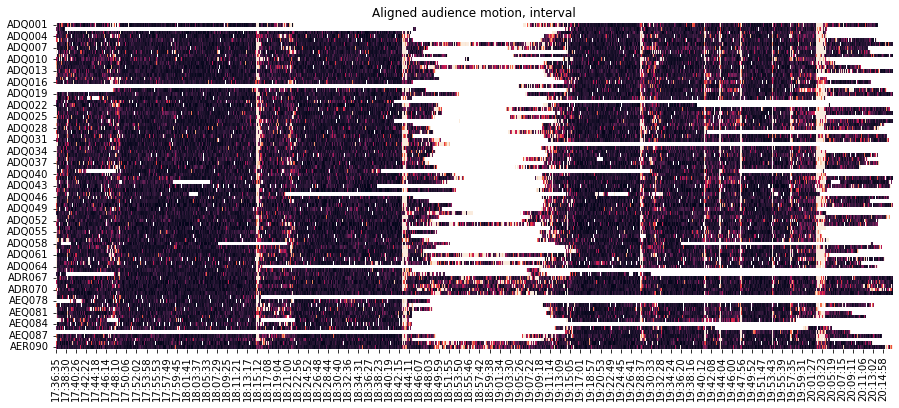

In [21]:
# now evaluate 
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[-1,:].name
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=10,cbar=False)

ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))
ax1.set_title('Aligned audience motion, interval')
#plt.savefig('./Plots/Realigned_Hall_segment.png',dpi = 300)
plt.show()

<AxesSubplot:>

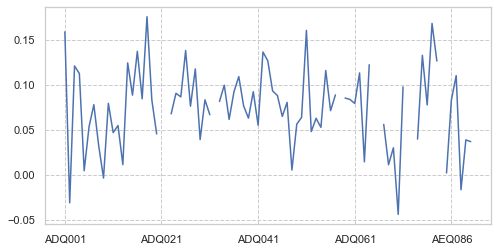

In [268]:
A = seg_df.corr(method = 'spearman')
A.median().plot()

In [269]:
Sub_Rels['Seg_Corr'] = 51
Sub_Rels.loc[Sub_Rels['Distance'] == -2.0,'Distance'] = 2.0

for i,row in Sub_Rels.iterrows():
    Sub_Rels.loc[i,'Seg_Corr'] = A[row['Participant_Code_1']][row['Participant_Code_2']]

In [270]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.016339,2.0,0.008170,0.948501,0.388087,0.004161
1,Familiarity,0.000783,1.0,0.000783,0.090919,0.763151,0.000200
2,Distance * Familiarity,0.056252,2.0,0.028126,3.265437,0.039079,0.014181
3,Residual,3.910405,454.0,0.008613,NaN,NaN,NaN


['2021-10-26 19:41:02', '2021-10-26 19:43:39']


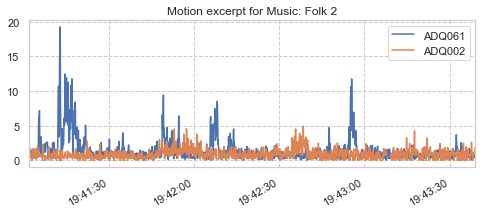

In [271]:
evN = 35
seg_start = Main_concert_times.iloc[evN,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = Main_concert_times.iloc[evN+1,:].name
row = Main_concert_times.iloc[evN,:]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
#seg_df = seg_df.fillna(0)

seg_df.loc[:,['ADQ061','ADQ002']].plot(figsize=[8,3])
plt.xlim([seg_start,seg_end])
plt.title('Motion excerpt for ' + row['Event_Type'] + ': '+ row['Event'])
plt.savefig('plots/Sample_pair.png',dpi=400)
plt.show()

In [272]:
pg.anova(dv="Seg_Corr",between = ["Distance","Familiarity"], data=Sub_Rels)

,Source,SS,DF,MS,F,p-unc,np2
0,Distance,0.016339,2.0,0.008170,0.948501,0.388087,0.004161
1,Familiarity,0.000783,1.0,0.000783,0.090919,0.763151,0.000200
2,Distance * Familiarity,0.056252,2.0,0.028126,3.265437,0.039079,0.014181
3,Residual,3.910405,454.0,0.008613,NaN,NaN,NaN


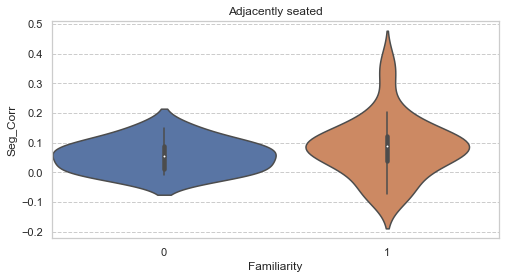

        Source  ddof1  ddof2         F     p-unc      np2
0  Familiarity      1     39  0.780087  0.382527  0.01961


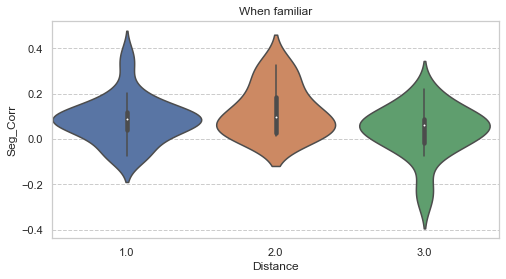

     Source  ddof1  ddof2        F     p-unc       np2
0  Distance      2     61  2.83887  0.066243  0.085152


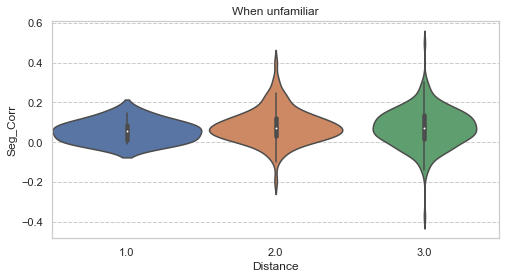

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    393  0.500615  0.606544  0.002541


In [273]:
Sub_Sub_Rels = Sub_Rels[Sub_Rels['Distance'] == 1.0]
sns.violinplot(x = 'Familiarity',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('Adjacently seated')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 1]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When familiar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

Sub_Sub_Rels = Sub_Rels[Sub_Rels['Familiarity'] == 0]
sns.violinplot(x = 'Distance',y = 'Seg_Corr',width = 1, data = Sub_Sub_Rels)
plt.title('When unfamiliar')
plt.show()
aov = pg.anova(dv="Seg_Corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

In [274]:
concert_times = pd.read_csv(public_time +'Events_Coarse.csv',",") #SV alignment for beeps

# concert_times.drop(concert_times.iloc[61].name,inplace=True)
# concert_times.drop(concert_times.iloc[22].name,inplace=True)
# concert_times.drop(concert_times.iloc[16].name,inplace=True)
concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('datetime')

# replace some of the terms
# event_type Audience Group to Applause, change Clapping to 


In [275]:
Main_concert_times.iloc[:10]

,time_s,time,events,event_type,Stream_Time_s,Event Duration,sequence
datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:36:53,-673.12,-673120,Speech,MCing,964.12,117.08,1
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:38:56,-550.16,-550160,Speech,MCing,1087.08,380.52,3
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:47:02,-63.68,-63680,Speech,MCing,1573.56,63.68,5
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,6
2021-10-26 17:48:20,14.38,14380,Clapping for musicians,Applause,1651.62,43.02,7
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8


In [276]:
corrs_set = pd.DataFrame()
for i in range(len(Main_concert_times)-1):
    als = Sub_Rels.copy()
    row = Main_concert_times.iloc[i]
    if row['Event Duration'] >15:
        seg_start = Main_concert_times.iloc[i].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
        seg_end = Main_concert_times.iloc[i+1].name
        print(str([seg_start,seg_end]) + ': ' + row['events'] + ', ' + row['event_type'])
        corr_name = 'Seg_corr'#
        als['Seg_N'] = row['sequence']
        als['Seg_event'] = row['events']
        als['Seg_type'] = row['event_type']
        als['Seg_dur'] = row['Event Duration']
        als[corr_name] = 0
        seg_df = aud_df.loc[seg_start:seg_end]
        #seg_df = seg_df.fillna(0)
        A = seg_df.corr(method = 'spearman')

        for i,row in Sub_Rels.iterrows():
            if row['Participant_Code_1'] in seg_df.columns:
                if row['Participant_Code_2'] in seg_df.columns:
                    als.loc[i,corr_name] = A[row['Participant_Code_1']][row['Participant_Code_2']]
        corrs_set = pd.concat([corrs_set,als],ignore_index=True)


['2021-10-26 17:36:35', '2021-10-26 17:36:53']: Clapping for MC, Applause
['2021-10-26 17:36:53', '2021-10-26 17:38:50']: Speech, MCing
['2021-10-26 17:38:56', '2021-10-26 17:45:16']: Speech, MCing
['2021-10-26 17:45:16', '2021-10-26 17:47:02']: Clapping for MC, Applause
['2021-10-26 17:47:02', '2021-10-26 17:48:06']: Speech, MCing
['2021-10-26 17:48:20', '2021-10-26 17:49:03']: Clapping for musicians, Applause
['2021-10-26 17:49:03', '2021-10-26 17:56:02']: Beethoven 1, Music
['2021-10-26 17:56:02', '2021-10-26 17:59:47']: Beethoven 2, Music
['2021-10-26 17:59:47', '2021-10-26 18:07:36']: Beethoven 3, Music
['2021-10-26 18:07:36', '2021-10-26 18:14:56']: Beethoven 4, Music
['2021-10-26 18:14:56', '2021-10-26 18:15:28']: Clapping for Beethoven, Applause
['2021-10-26 18:15:28', '2021-10-26 18:15:48']: Speech, MCing
['2021-10-26 18:15:48', '2021-10-26 18:21:19']: Survey for Beethoven, Survey
['2021-10-26 18:21:30', '2021-10-26 18:22:20']: Clapping for Musicians, Applause
['2021-10-26 18:

In [203]:
corrs_set['Distance']= corrs_set['Distance'].abs()

In [221]:
sns.set(rc={'figure.figsize':(7,3)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

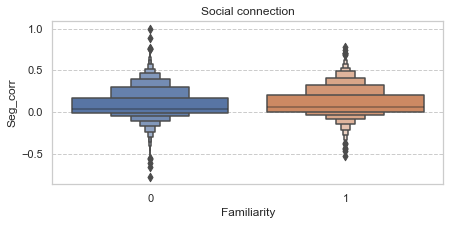

        Source  ddof1  ddof2          F         p-unc       np2
0  Familiarity      1  21378  36.330702  1.692492e-09  0.001697


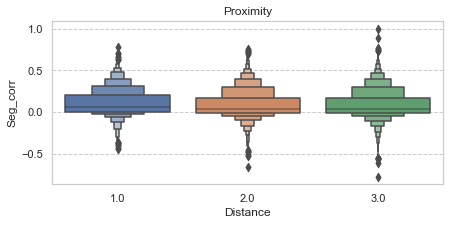

     Source  ddof1  ddof2          F         p-unc       np2
0  Distance      2  21377  14.391377  5.676861e-07  0.001345


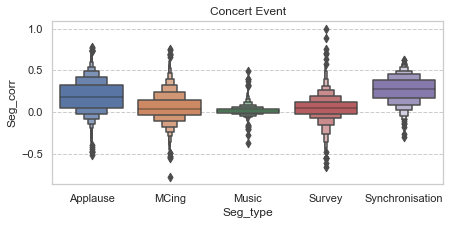

     Source  ddof1  ddof2            F  p-unc       np2
0  Seg_type      4  21375  1519.961304    0.0  0.221449


In [222]:
#sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
#sns.set_theme(style="whitegrid")

sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = corrs_set)
plt.title('Social connection')
plt.savefig('plots/PairCorr_allEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=corrs_set)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr', data = corrs_set)
plt.title('Proximity')
plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=corrs_set)
print(aov)

sns.boxenplot(x = 'Seg_type',y = 'Seg_corr', data = corrs_set)
plt.title('Concert Event')
plt.savefig('plots/PairCorr_allEvents_EventType.png',dpi = 400)

plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_type", data=corrs_set)
print(aov)


In [223]:
pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_type'], data=corrs_set)

,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.305635,1.0,0.305635,14.454660,0.000144,0.000677
1,Distance,0.162202,2.0,0.081101,3.835581,0.021604,0.000359
2,Seg_type,128.899240,4.0,32.224810,1524.033631,0.000000,0.222113
3,Familiarity * Distance,0.110526,2.0,0.055263,2.613602,0.073294,0.000245
4,Familiarity * Seg_type,0.272405,4.0,0.068101,3.220762,0.011878,0.000603
5,Distance * Seg_type,0.071650,8.0,0.008956,0.423576,0.907646,0.000159
6,Familiarity * Distance * Seg_type,0.218908,8.0,0.027363,1.294124,0.241188,0.000485
7,Residual,451.433407,21350.0,0.021144,NaN,NaN,NaN


In [225]:
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid", {
    "ytick.major.size": 1,
    "ytick.minor.size": 0.5,
    'grid.linestyle': '--',
    "xtick.major.size": 1,
    "xtick.minor.size": 0.5,
    'grid.linestyle': '--'
 })

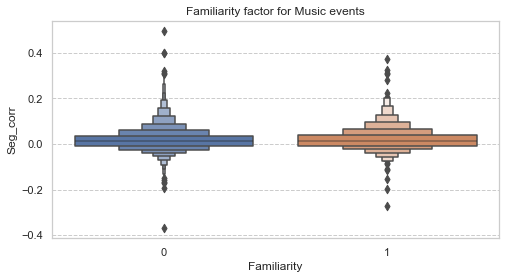

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1   6718  3.909795  0.048046  0.000582


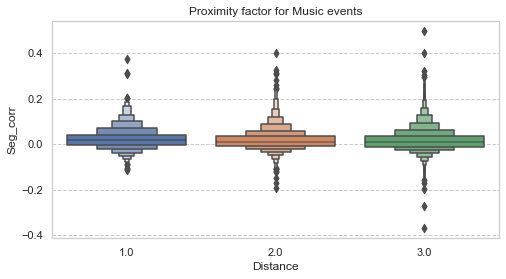

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   6717  6.503772  0.001507  0.001933


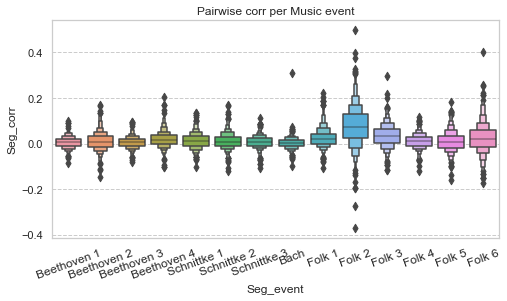

      Source  ddof1  ddof2          F          p-unc      np2
0  Seg_event     13   6706  83.167024  3.608196e-206  0.13884


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.000136,1.0,0.000136,0.068405,7.936818e-01,0.000010
1,Distance,0.021859,2.0,0.010930,5.492822,4.134950e-03,0.001653
2,Seg_event,2.165829,13.0,0.166602,83.727119,2.354073e-207,0.140910
3,Familiarity * Distance,0.007587,2.0,0.003794,1.906498,1.486813e-01,0.000574
4,Familiarity * Seg_event,0.041308,13.0,0.003178,1.596882,7.814392e-02,0.003119
5,Distance * Seg_event,0.085981,26.0,0.003307,1.661939,1.863138e-02,0.006469
6,Familiarity * Distance * Seg_event,0.081157,26.0,0.003121,1.568697,3.299413e-02,0.006109
7,Residual,13.204473,6636.0,0.001990,NaN,NaN,NaN


In [226]:
# look at within type patters
Ev = 'Music'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title('Familiarity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Familiarity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title('Proximity factor for ' + Ev + ' events')
plt.savefig('plots/PairCorr_MusicEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title('Pairwise corr per ' + Ev + ' event')
plt.savefig('plots/PairCorr_MusicEvents_Peices.png',dpi = 400)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

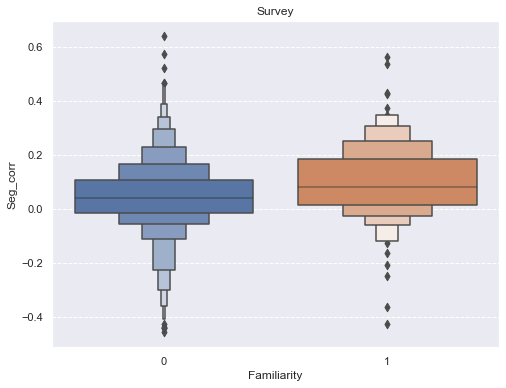

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   1343  24.093733  0.000001  0.017624


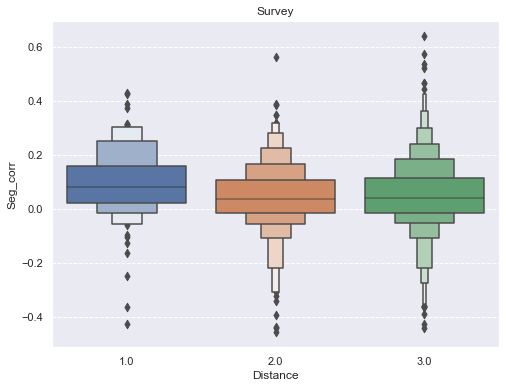

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   1342  7.158177  0.000809  0.010555


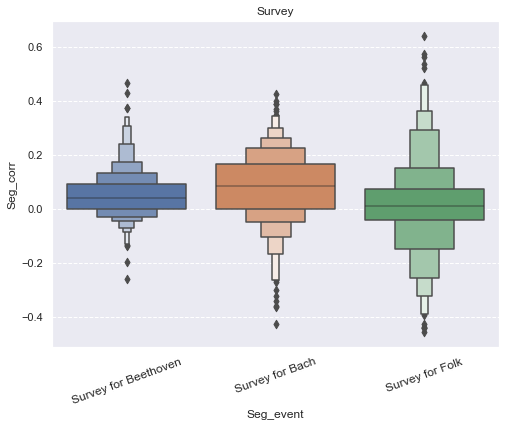

      Source  ddof1  ddof2          F         p-unc       np2
0  Seg_event      2   1342  27.690735  1.642807e-12  0.039632


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.146430,1.0,0.146430,9.876679,1.710920e-03,0.007388
1,Distance,0.027649,2.0,0.013825,0.932472,3.938371e-01,0.001403
2,Seg_event,0.830461,2.0,0.415230,28.007217,1.219926e-12,0.040502
3,Familiarity * Distance,0.077585,2.0,0.038793,2.616556,7.343088e-02,0.003928
4,Familiarity * Seg_event,0.112846,2.0,0.056423,3.805719,2.248637e-02,0.005703
5,Distance * Seg_event,0.060894,4.0,0.015224,1.026823,3.921092e-01,0.003086
6,Familiarity * Distance * Seg_event,0.373457,4.0,0.093364,6.297395,5.096022e-05,0.018629
7,Residual,19.673882,1327.0,0.014826,NaN,NaN,NaN


In [177]:
# look at within type patters
Ev = 'Survey'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_event',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_event", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_event'], data=Sub_Sub_Rels)

In [185]:
corrs_set[corrs_set['Seg_event'] == Ev]

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship,Seg_Corr,Seg_N,Seg_event,Seg_type,Seg_dur,Seg_corr


In [183]:
# look at within type patters
Ev = 'Applause'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_event'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

ValueError: min() arg is an empty sequence

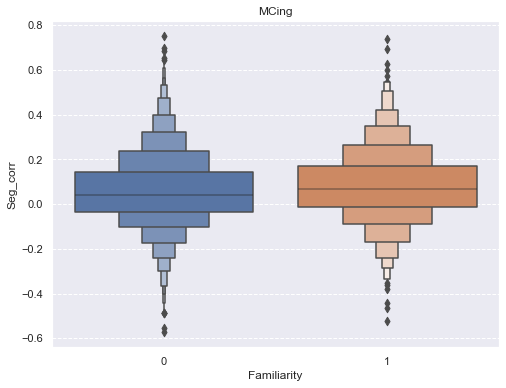

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   5582  12.615124  0.000386  0.002255


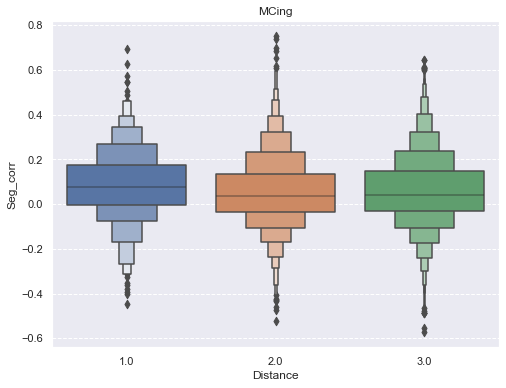

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   5581  6.614581  0.001351  0.002365


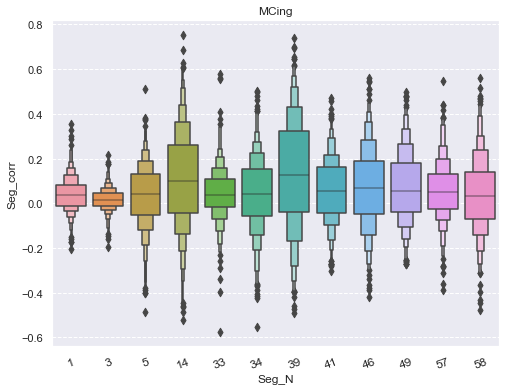

  Source  ddof1  ddof2          F         p-unc       np2
0  Seg_N     11   5572  20.794515  6.402947e-42  0.039433


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.088744,1.0,0.088744,3.518235,6.074988e-02,0.000638
1,Distance,0.101602,2.0,0.050801,2.014005,1.335513e-01,0.000730
2,Seg_N,5.798593,11.0,0.527145,20.898570,3.861304e-42,0.040036
3,Familiarity * Distance,0.151283,2.0,0.075642,2.998796,4.992840e-02,0.001087
4,Familiarity * Seg_N,0.548136,11.0,0.049831,1.975525,2.675454e-02,0.003927
5,Distance * Seg_N,0.603042,22.0,0.027411,1.086705,3.525430e-01,0.004319
6,Familiarity * Distance * Seg_N,0.588216,22.0,0.026737,1.059988,3.842545e-01,0.004213
7,Residual,139.034493,5512.0,0.025224,NaN,NaN,NaN


In [150]:
# look at within type patters
Ev = 'MCing'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

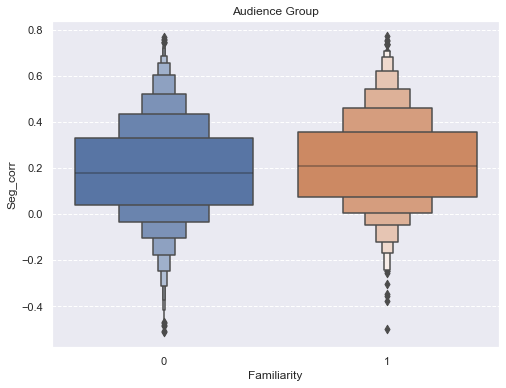

        Source  ddof1  ddof2          F     p-unc       np2
0  Familiarity      1   7010  17.814801  0.000025  0.002535


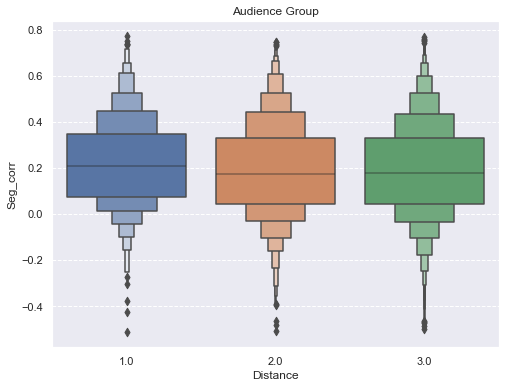

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2   7009  4.677732  0.009329  0.001333


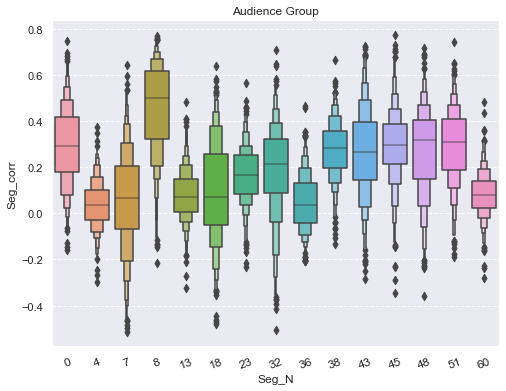

  Source  ddof1  ddof2           F  p-unc       np2
0  Seg_N     14   6997  291.922613    0.0  0.368725


,Source,SS,DF,MS,F,p-unc,np2
0,Familiarity,0.397796,1.0,0.397796,14.750684,0.000124,0.002126
1,Distance,0.036178,2.0,0.018089,0.670756,0.511355,0.000194
2,Seg_N,110.486072,14.0,7.891862,292.638201,0.000000,0.371809
3,Familiarity * Distance,0.164154,2.0,0.082077,3.043505,0.047731,0.000879
4,Familiarity * Seg_N,0.430641,14.0,0.030760,1.140615,0.315575,0.002302
5,Distance * Seg_N,0.705743,28.0,0.025205,0.934631,0.563736,0.003766
6,Familiarity * Distance * Seg_N,0.521445,28.0,0.018623,0.690561,0.887154,0.002786
7,Residual,186.672384,6922.0,0.026968,NaN,NaN,NaN


In [151]:
# look at within type patters
Ev = 'Audience Group'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)

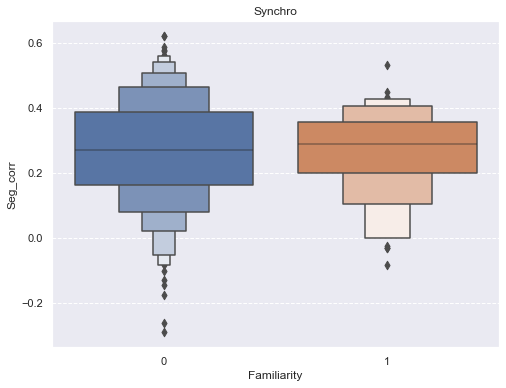

        Source  ddof1  ddof2         F     p-unc       np2
0  Familiarity      1    461  0.063511  0.801143  0.000138


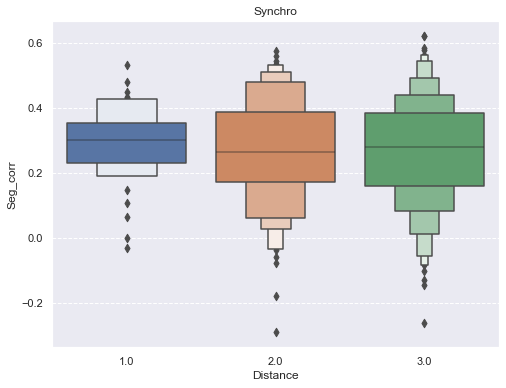

     Source  ddof1  ddof2         F     p-unc       np2
0  Distance      2    460  0.390087  0.677222  0.001693


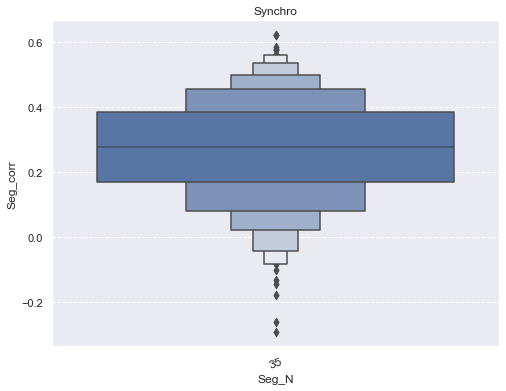

  Source  ddof1  ddof2  np2
0  Seg_N      0    462  0.0


C:\Users\finnu\Anaconda3\lib\site-packages\pingouin\parametric.py:979: RuntimeWarning: invalid value encountered in double_scalars
  msbetween = ssbetween / ddof1


ValueError: must have at least one row in constraint matrix

In [154]:
# look at within type patters
Ev = 'Synchronisation'
Sub_Sub_Rels = corrs_set[corrs_set['Seg_type'] == Ev]


sns.boxenplot(x = 'Familiarity',y = 'Seg_corr', data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Familiarity", data=Sub_Sub_Rels)
print(aov)


sns.boxenplot(x = 'Distance',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Distance", data=Sub_Sub_Rels)
print(aov)

sns.boxenplot(x = 'Seg_N',y = 'Seg_corr',data = Sub_Sub_Rels)
plt.xticks(rotation='20',fontsize=12)
plt.title(Ev)
plt.show()
aov = pg.anova(dv="Seg_corr",between = "Seg_N", data=Sub_Sub_Rels)
print(aov)

pg.anova(dv="Seg_corr",between = ["Familiarity","Distance",'Seg_N'], data=Sub_Sub_Rels)